In [15]:
install.packages("leaps")

Installing package into ‘/home/jupyter/R/x86_64-pc-linux-gnu-library/4.3’
(as ‘lib’ is unspecified)



In [16]:
library(ggplot2)
library(tidyverse)
library(leaps)

In [6]:
df0 = read.table("./data/data.csv", sep = ",", header=T)

In [10]:
# drop variables we don't use
df1 = df0 |> select(-Release.Date..US., -Oscar.Detail, -X..of.Gross.earned.abroad)

In [11]:
colnames(df1) = c("film", "year", "rt_cr", "meta_cr", "rt_au", "meta_au", "pr_genre", "op_weekend", "domestic_gross", "foreign_gross", "world_gross", "budget", "oscar", "distr", "imdb")


In [9]:
head(df)

,film,year,rt_cr,meta_cr,rt_au,meta_au,pr_genre,op_weekend,domestic_gross,foreign_gross,world_gross,budget,oscar,distr,imdb
,<chr>,<int>,<int>,<int>,<int>,<int>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>
1,Ambulance,2022,69,55,88,56,thriller,8.7,22.3,29.5,51.8,40.0,,Universal Pictures,6.1
2,Amsterdam,2022,32,48,62,52,comedy,6.4,14.9,14.5,29.4,80.0,,Walt Disney Studios Motion Pictures,6.1
3,Armageddon Time,2022,75,74,48,66,drama,0.1,1.9,4.7,6.6,15.0,,Universal Pictures,6.5
4,Babylon,2022,57,61,52,70,comedy,3.6,15.4,47.9,63.3,110.0,,Paramount Pictures,7.1
5,Barbarian,2022,92,78,71,74,thriller,10.5,40.8,4.5,45.4,4.5,,20th Century Studios,7.0
6,Beast,2022,68,54,77,48,thriller,11.6,31.8,27.3,59.2,36.0,,Universal Pictures,5.6


In [12]:
df = df1 |> select(-film, -foreign_gross, -world_gross)

In [13]:
head(df)

,year,rt_cr,meta_cr,rt_au,meta_au,pr_genre,op_weekend,domestic_gross,budget,oscar,distr,imdb
,<int>,<int>,<int>,<int>,<int>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>
1,2022,69,55,88,56,thriller,8.7,22.3,40.0,,Universal Pictures,6.1
2,2022,32,48,62,52,comedy,6.4,14.9,80.0,,Walt Disney Studios Motion Pictures,6.1
3,2022,75,74,48,66,drama,0.1,1.9,15.0,,Universal Pictures,6.5
4,2022,57,61,52,70,comedy,3.6,15.4,110.0,,Paramount Pictures,7.1
5,2022,92,78,71,74,thriller,10.5,40.8,4.5,,20th Century Studios,7.0
6,2022,68,54,77,48,thriller,11.6,31.8,36.0,,Universal Pictures,5.6


In [23]:
s = regsubsets(I(log(domestic_gross) ~ year + rt_cr + meta_cr + rt_au + meta_au + op_weekend + budget + oscar + imdb), data = df, method = "exhaustive")

In [25]:
ss = summary(s)
ss$which

,(Intercept),year,rt_cr,meta_cr,rt_au,meta_au,op_weekend,budget,oscarOscar Winner,imdb
1,TRUE,FALSE,FALSE,FALSE,FALSE,FALSE,TRUE,FALSE,FALSE,FALSE
2,TRUE,FALSE,FALSE,FALSE,FALSE,FALSE,TRUE,TRUE,FALSE,FALSE
3,TRUE,FALSE,FALSE,FALSE,FALSE,FALSE,TRUE,TRUE,FALSE,TRUE
4,TRUE,FALSE,FALSE,TRUE,FALSE,FALSE,TRUE,TRUE,FALSE,TRUE
5,TRUE,FALSE,FALSE,TRUE,FALSE,FALSE,TRUE,TRUE,TRUE,TRUE
6,TRUE,FALSE,FALSE,TRUE,TRUE,FALSE,TRUE,TRUE,TRUE,TRUE
7,TRUE,TRUE,FALSE,TRUE,TRUE,FALSE,TRUE,TRUE,TRUE,TRUE
8,TRUE,TRUE,FALSE,TRUE,TRUE,TRUE,TRUE,TRUE,TRUE,TRUE


In [26]:
ss$cp

[1] 18.379586  9.047871  3.943466  3.526744  3.848634  5.085848  6.127082
[8]  8.006243

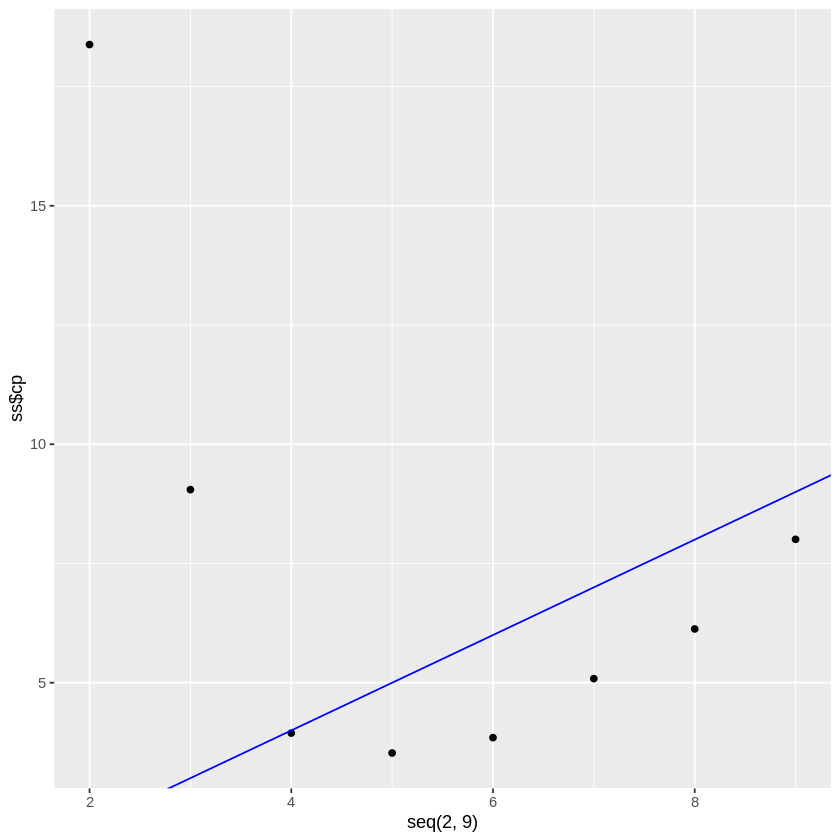

In [34]:
ggplot() +
  geom_point(aes(x = seq(2, 9), y = ss$cp)) +
  geom_abline(intercept = 0, slope = 1, color = "blue")

From this plot, It seems like a model with 4 parameters ie `intercept`, `op_weekend`, `budget`, `imdb` is good.

# Model 1

In [74]:
m1 = lm(I(log(domestic_gross)) ~ op_weekend + budget + imdb, data = df)
summary(m1)


Call:
lm(formula = I(log(domestic_gross)) ~ op_weekend + budget + imdb, 
    data = df)

Residuals:
    Min      1Q  Median      3Q     Max 
-4.3393 -0.5435  0.2253  0.7246  1.6277 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept) 1.429366   0.464664   3.076 0.002334 ** 
op_weekend  0.017646   0.002231   7.911 8.69e-14 ***
budget      0.004889   0.001407   3.475 0.000604 ***
imdb        0.193215   0.072482   2.666 0.008191 ** 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.9803 on 246 degrees of freedom
Multiple R-squared:  0.5167,	Adjusted R-squared:  0.5108 
F-statistic: 87.65 on 3 and 246 DF,  p-value: < 2.2e-16


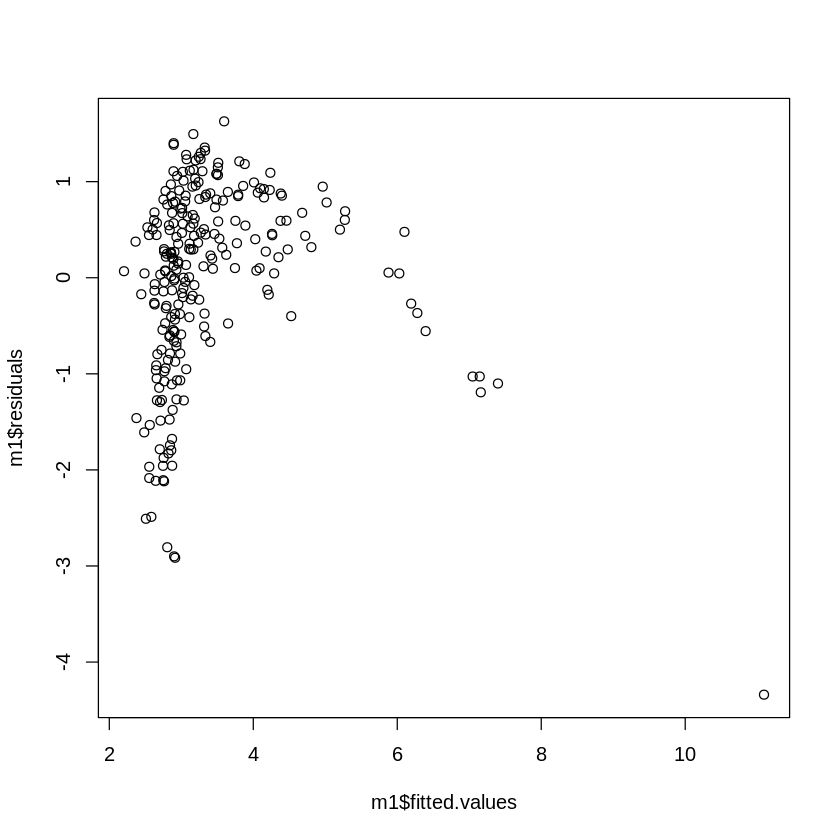

In [75]:
# residual plot
plot(m1$fitted.values, m1$residuals)

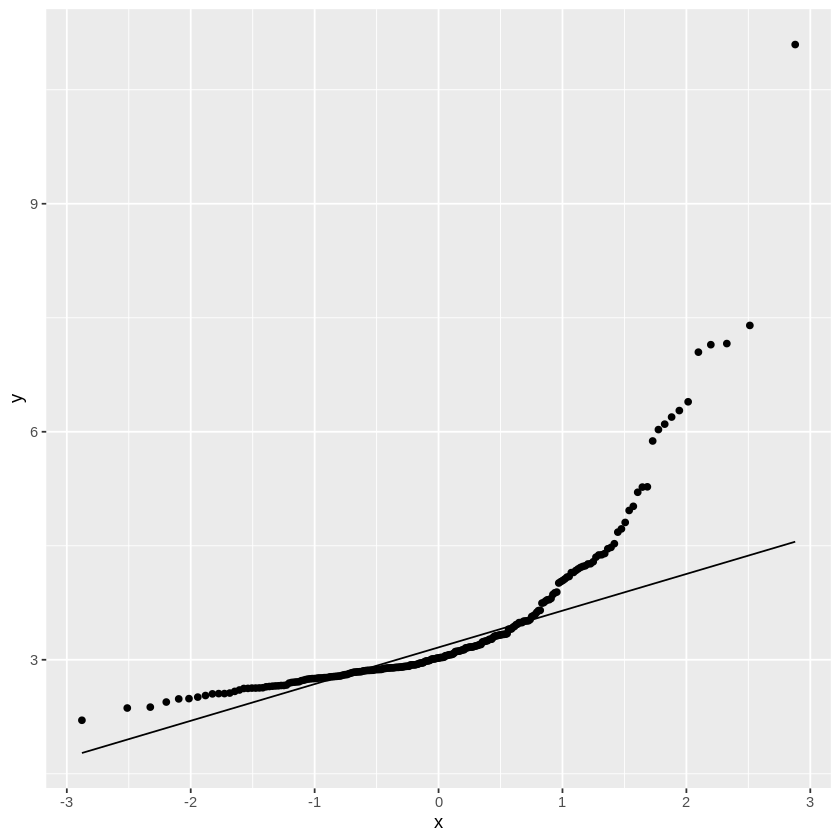

In [76]:
# qq plot
ggplot() + stat_qq(aes(sample = m1$fitted.values)) + stat_qq_line(aes(sample =  m1$fitted.values))

I can say `m1` is probably not a good model

# Models involving categorical features
We notice that opening weekend is already part of gross so there is too much assocaition. It might better serve our research question by excluding opening weekend because we want to know what factors are associated with domestic gross, and everybody knows opening weekend is definitely associated with domestic gross.

Let's explore factors `pr_genre` and `distributor`

In [40]:
cor(df$domestic_gross, df$op_weekend)

[1] 0.9487147

In [43]:
df |> group_by(distr) |>
summarise(mean_dom_gross = mean(domestic_gross)) |>
arrange(desc(mean_dom_gross)) |>
head(10)

distr,mean_dom_gross
<chr>,<dbl>
Walt Disney Studios,382.71111
Walt Disney Studios Motion Pictures,205.94286
Warner Bros. Pictures,86.10714
Paramount Pictures,85.61364
Sony Pictures,72.31724
Universal Pictures,67.30000
20th Century Fox,53.97500
Lionsgate,47.81250
STX Entertainment,38.07778


In [49]:
df |> group_by(pr_genre) |>
summarise(mean_dom_gross = mean(domestic_gross)) |>
arrange(desc(mean_dom_gross)) 

pr_genre,mean_dom_gross
<chr>,<dbl>
action,140.33125
adventure,90.38462
NA,75.31791
horror,47.71000
romance,37.50000
thriller,27.86429
drama,25.05000
animation,17.80000
comedy,17.24000


In [52]:
big7 = c("Walt Disney Studios", "Walt Disney Studios Motion Pictures", "Warner Bros. Pictures", "Paramount Pictures", "Sony Pictures", "Universal Pictures", "20th Century Fox")
df3 = df
df3$distr[!(df$distr %in% big7)] = "other"
# gen2 = c("action", "adventure")
# df3$pr_genre[!(df$pr_genre %in% gen2)] = "other"

In [53]:
head(df3)

,year,rt_cr,meta_cr,rt_au,meta_au,pr_genre,op_weekend,domestic_gross,budget,oscar,distr,imdb
,<int>,<int>,<int>,<int>,<int>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>
1,2022,69,55,88,56,thriller,8.7,22.3,40.0,,Universal Pictures,6.1
2,2022,32,48,62,52,comedy,6.4,14.9,80.0,,Walt Disney Studios Motion Pictures,6.1
3,2022,75,74,48,66,drama,0.1,1.9,15.0,,Universal Pictures,6.5
4,2022,57,61,52,70,comedy,3.6,15.4,110.0,,Paramount Pictures,7.1
5,2022,92,78,71,74,thriller,10.5,40.8,4.5,,other,7.0
6,2022,68,54,77,48,thriller,11.6,31.8,36.0,,Universal Pictures,5.6


In [58]:
s = regsubsets(I(log(domestic_gross) ~ pr_genre + distr + budget + oscar + imdb), data = df, method = "backward")

Warning message in leaps.setup(x, y, wt = wt, nbest = nbest, nvmax = nvmax, force.in = force.in, :
“1  linear dependencies found”


Reordering variables and trying again:


,(Intercept),pr_genreadventure,pr_genreanimation,pr_genrebiography,pr_genrecomedy,pr_genrecrime,pr_genredrama,pr_genrefantasy,pr_genrehorror,pr_genreromance,⋯,distrSTX Entertainment,distrTriStar Pictures,distrUnited Artists Releasing,distrUniversal Pictures,distrVertigo Films,distrWalt Disney Studios Motion Pictures,distrWarner Bros. Pictures,budget,oscarOscar Winner,imdb
1,TRUE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,⋯,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,TRUE,FALSE,FALSE
2,TRUE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,⋯,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,TRUE,FALSE,TRUE
3,TRUE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,TRUE,FALSE,⋯,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,TRUE,FALSE,TRUE
4,TRUE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,TRUE,FALSE,⋯,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,TRUE,FALSE,TRUE
5,TRUE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,TRUE,FALSE,⋯,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,TRUE,FALSE,TRUE
6,TRUE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,TRUE,FALSE,⋯,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,TRUE,FALSE,TRUE
7,TRUE,FALSE,FALSE,FALSE,FALSE,FALSE,TRUE,FALSE,TRUE,FALSE,⋯,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,TRUE,FALSE,TRUE
8,TRUE,FALSE,FALSE,FALSE,FALSE,TRUE,TRUE,FALSE,TRUE,FALSE,⋯,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,TRUE,FALSE,TRUE
9,TRUE,FALSE,FALSE,FALSE,FALSE,TRUE,TRUE,FALSE,TRUE,FALSE,⋯,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,TRUE,FALSE,TRUE


[1] 53.80129 42.49758 31.31757 26.00872 23.96117 22.89111 21.55194 19.48551
[9] 17.32581

In [60]:
ss = summary(s)
ss$which
ss$cp

,(Intercept),pr_genreadventure,pr_genreanimation,pr_genrebiography,pr_genrecomedy,pr_genrecrime,pr_genredrama,pr_genrefantasy,pr_genrehorror,pr_genreromance,⋯,distrSTX Entertainment,distrTriStar Pictures,distrUnited Artists Releasing,distrUniversal Pictures,distrVertigo Films,distrWalt Disney Studios Motion Pictures,distrWarner Bros. Pictures,budget,oscarOscar Winner,imdb
1,TRUE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,⋯,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,TRUE,FALSE,FALSE
2,TRUE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,⋯,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,TRUE,FALSE,TRUE
3,TRUE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,TRUE,FALSE,⋯,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,TRUE,FALSE,TRUE
4,TRUE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,TRUE,FALSE,⋯,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,TRUE,FALSE,TRUE
5,TRUE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,TRUE,FALSE,⋯,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,TRUE,FALSE,TRUE
6,TRUE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,TRUE,FALSE,⋯,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,TRUE,FALSE,TRUE
7,TRUE,FALSE,FALSE,FALSE,FALSE,FALSE,TRUE,FALSE,TRUE,FALSE,⋯,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,TRUE,FALSE,TRUE
8,TRUE,FALSE,FALSE,FALSE,FALSE,TRUE,TRUE,FALSE,TRUE,FALSE,⋯,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,TRUE,FALSE,TRUE
9,TRUE,FALSE,FALSE,FALSE,FALSE,TRUE,TRUE,FALSE,TRUE,FALSE,⋯,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,TRUE,FALSE,TRUE


[1] 53.80129 42.49758 31.31757 26.00872 23.96117 22.89111 21.55194 19.48551
[9] 17.32581

Warning message:
“Removed 3 rows containing missing values (`geom_point()`).”


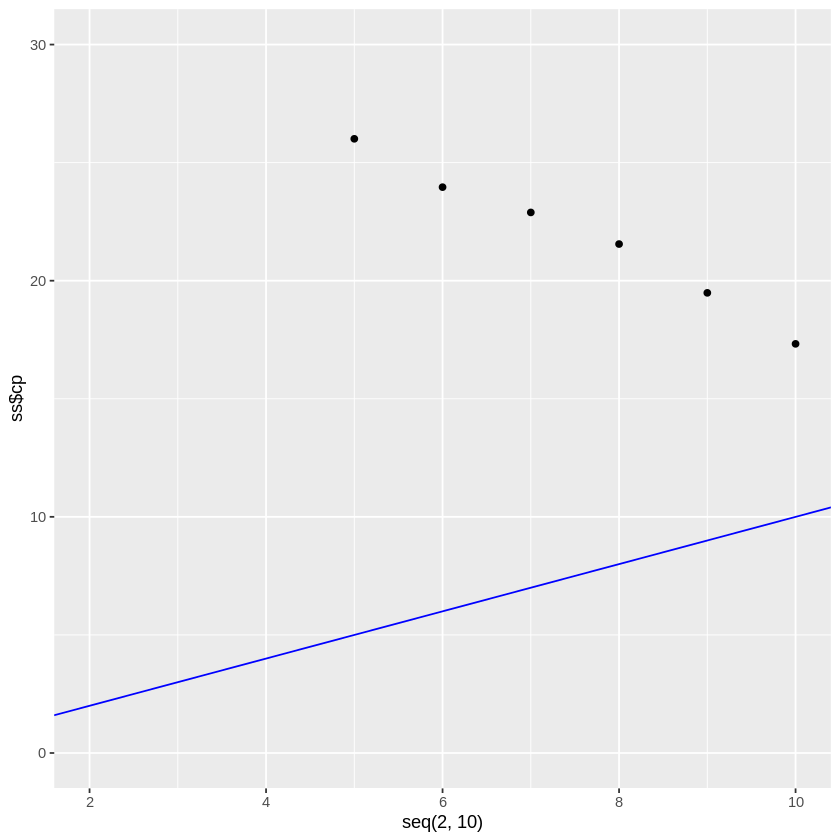

In [63]:

ggplot() +
  geom_point(aes(x = seq(2, 10), y = ss$cp)) +
  geom_abline(intercept = 0, slope = 1, color = "blue") +
  ylim(0, 30)

From this, I beleive including both `pr_genre` and `distr` is not a wise choice.

Maybe including only either of these?

In [65]:
s = regsubsets(I(log(domestic_gross) ~  distr + budget + oscar + imdb), data = df, method = "exhaustive")

In [66]:
ss = summary(s)
ss$which
ss$cp

,(Intercept),distr20th Century Fox,distr20th Century Studios,distrA24,distrAmazon Studios,distrAnnapurna Pictures,distrAviron Pictures,distrBleecker Street,distrBloody Disgusting,distrEntertainment Studios,⋯,distrTriStar Pictures,distrUnited Artists Releasing,distrUniversal Pictures,distrVertigo Films,distrWalt Disney Studios,distrWalt Disney Studios Motion Pictures,distrWarner Bros. Pictures,budget,oscarOscar Winner,imdb
1,TRUE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,⋯,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,TRUE,FALSE,FALSE
2,TRUE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,⋯,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,TRUE,FALSE,TRUE
3,TRUE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,⋯,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,TRUE,FALSE,TRUE
4,TRUE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,⋯,FALSE,FALSE,TRUE,FALSE,FALSE,FALSE,FALSE,TRUE,FALSE,TRUE
5,TRUE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,⋯,FALSE,FALSE,TRUE,FALSE,FALSE,FALSE,FALSE,TRUE,FALSE,TRUE
6,TRUE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,⋯,FALSE,FALSE,TRUE,FALSE,FALSE,FALSE,FALSE,TRUE,FALSE,TRUE
7,TRUE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,⋯,FALSE,FALSE,TRUE,FALSE,FALSE,FALSE,TRUE,TRUE,FALSE,TRUE
8,TRUE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,⋯,FALSE,FALSE,TRUE,FALSE,TRUE,FALSE,TRUE,TRUE,FALSE,TRUE


[1] 75.86840 60.17690 49.43791 40.97567 35.62996 32.52378 27.94088 22.98874

Warning message:
“Removed 6 rows containing missing values (`geom_point()`).”


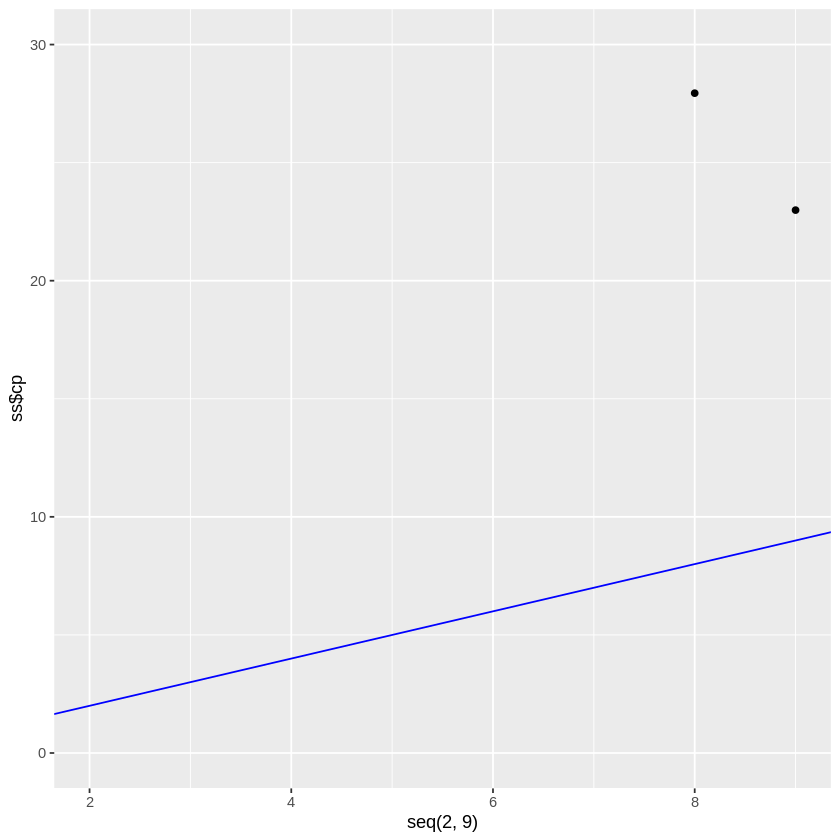

In [69]:
ggplot() +
  geom_point(aes(x = seq(2, 9), y = ss$cp)) +
  geom_abline(intercept = 0, slope = 1, color = "blue") +
  ylim(0, 30)

Not very good, cp wise

In [70]:
s = regsubsets(I(log(domestic_gross) ~  pr_genre + budget + oscar + imdb), data = df, method = "exhaustive")

In [71]:
ss = summary(s)
ss$which
ss$cp

,(Intercept),pr_genreadventure,pr_genreanimation,pr_genrebiography,pr_genrecomedy,pr_genrecrime,pr_genredrama,pr_genrefantasy,pr_genrehorror,pr_genreromance,pr_genrethriller,budget,oscarOscar Winner,imdb
1,TRUE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,TRUE,FALSE,FALSE
2,TRUE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,TRUE,FALSE,TRUE
3,TRUE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,TRUE,FALSE,FALSE,TRUE,FALSE,TRUE
4,TRUE,FALSE,FALSE,FALSE,FALSE,FALSE,TRUE,FALSE,TRUE,FALSE,FALSE,TRUE,FALSE,TRUE
5,TRUE,FALSE,FALSE,FALSE,FALSE,TRUE,TRUE,FALSE,TRUE,FALSE,FALSE,TRUE,FALSE,TRUE
6,TRUE,FALSE,FALSE,FALSE,FALSE,TRUE,TRUE,FALSE,TRUE,FALSE,FALSE,TRUE,TRUE,TRUE
7,TRUE,FALSE,FALSE,FALSE,FALSE,TRUE,TRUE,TRUE,TRUE,FALSE,FALSE,TRUE,TRUE,TRUE
8,TRUE,FALSE,FALSE,TRUE,FALSE,TRUE,TRUE,TRUE,TRUE,FALSE,FALSE,TRUE,TRUE,TRUE


[1] 20.754474 12.024779  3.394849  3.422031  2.686916  3.017952  3.464161
[8]  4.640757

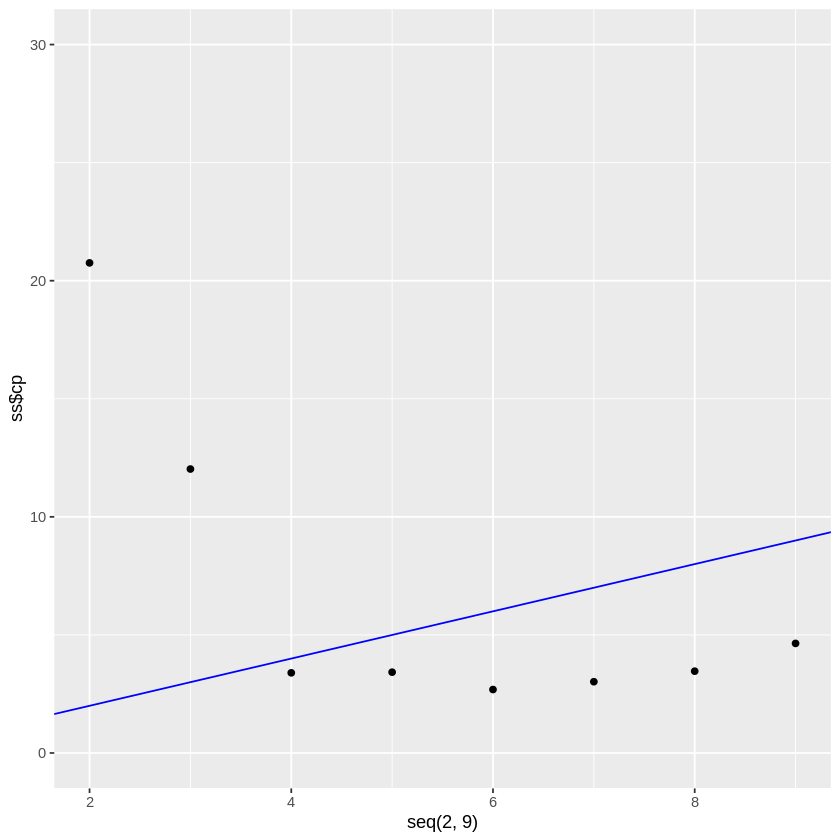

In [73]:
ggplot() +
  geom_point(aes(x = seq(2, 9), y = ss$cp)) +
  geom_abline(intercept = 0, slope = 1, color = "blue") +
  ylim(0, 30)

In [77]:
m2 = lm(I(log(domestic_gross)) ~ pr_genre + budget + imdb, data = df)

In [78]:
summary(m2)


Call:
lm(formula = I(log(domestic_gross)) ~ pr_genre + budget + imdb, 
    data = df)

Residuals:
    Min      1Q  Median      3Q     Max 
-3.2035 -0.7447  0.0488  0.8526  2.1950 

Coefficients:
                   Estimate Std. Error t value Pr(>|t|)    
(Intercept)       -0.699115   0.807965  -0.865 0.388804    
pr_genreadventure  0.096547   0.369828   0.261 0.794544    
pr_genreanimation  0.147038   1.129412   0.130 0.896659    
pr_genrebiography -1.099280   1.144809  -0.960 0.339084    
pr_genrecomedy    -0.194060   0.398280  -0.487 0.627072    
pr_genrecrime     -0.930337   0.594495  -1.565 0.120527    
pr_genredrama     -0.520343   0.366134  -1.421 0.158146    
pr_genrefantasy   -1.397627   1.125177  -1.242 0.216875    
pr_genrehorror     0.965833   0.465978   2.073 0.040581 *  
pr_genreromance   -0.044731   0.575503  -0.078 0.938191    
pr_genrethriller   0.030280   0.400046   0.076 0.939804    
budget             0.014203   0.002313   6.142 1.39e-08 ***
imdb               0.489

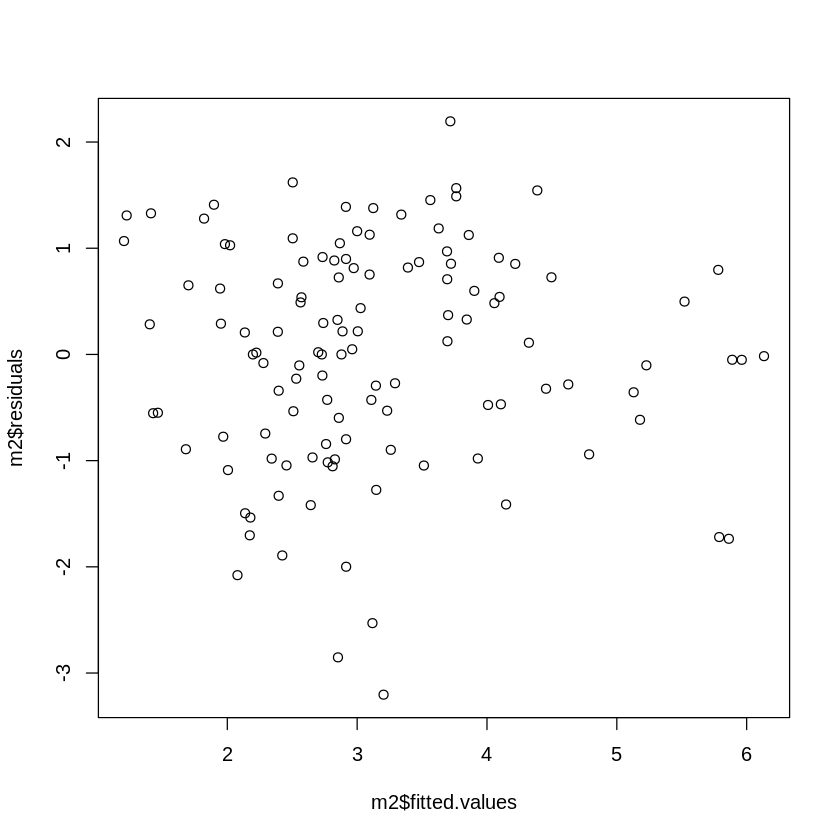

In [79]:
plot(m2$fitted.values, m2$residuals)

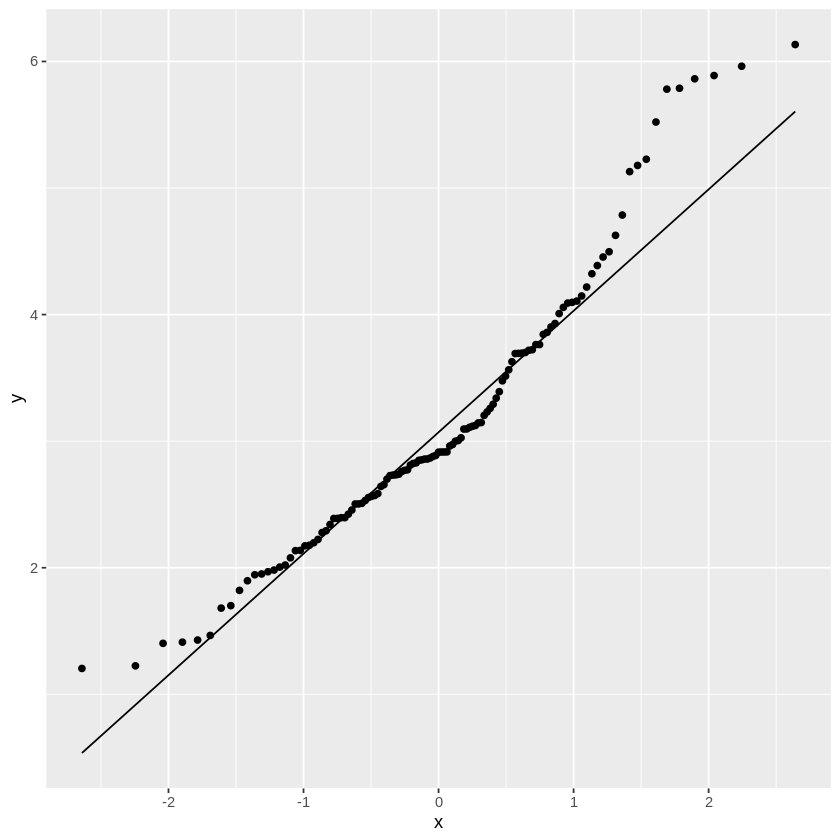

In [80]:
ggplot() + stat_qq(aes(sample = m2$fitted.values)) + stat_qq_line(aes(sample =  m2$fitted.values))

It looks much better than before. While there's probably violation of normality assumption, residual plot seems normal.
What if I convert pr_genre into binary feature?

In [82]:
df4 = df
df4$pr_genre[df$pr_genre != "horror"] = "other"

In [91]:
df4$pr_genre = as.factor(df4$pr_genre)
df4$pr_genre = relevel(df4$pr_genre, ref = "other")

In [169]:
m3 = lm(I(log(domestic_gross)) ~ pr_genre + budget + imdb, data = df4)
q3 = lm(I(log(domestic_gross)) ~ pr_genre + poly(budget,2) + imdb, data = df4)

In [170]:
summary(m3)
summary(q3)
AIC(m3)
AIC(q3)


Call:
lm(formula = I(log(domestic_gross)) ~ pr_genre + budget + imdb, 
    data = df4)

Residuals:
     Min       1Q   Median       3Q      Max 
-2.82950 -0.81234 -0.00336  0.77147  2.46009 

Coefficients:
                Estimate Std. Error t value Pr(>|t|)    
(Intercept)    -0.599101   0.765903  -0.782 0.435668    
pr_genrehorror  1.219757   0.373149   3.269 0.001418 ** 
budget          0.015885   0.001687   9.414 5.23e-16 ***
imdb            0.427834   0.119840   3.570 0.000519 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 1.094 on 117 degrees of freedom
  (129 observations deleted due to missingness)
Multiple R-squared:  0.4832,	Adjusted R-squared:   0.47 
F-statistic: 36.47 on 3 and 117 DF,  p-value: < 2.2e-16



Call:
lm(formula = I(log(domestic_gross)) ~ pr_genre + poly(budget, 
    2) + imdb, data = df4)

Residuals:
    Min      1Q  Median      3Q     Max 
-2.8641 -0.7330  0.1411  0.8511  2.1136 

Coefficients:
                 Estimate Std. Error t value Pr(>|t|)    
(Intercept)        0.3061     0.7465   0.410 0.682474    
pr_genrehorror     1.4441     0.3715   3.888 0.000169 ***
poly(budget, 2)1  14.8082     1.6677   8.879 9.93e-15 ***
poly(budget, 2)2  -5.9407     2.1224  -2.799 0.006004 ** 
imdb               0.4202     0.1165   3.606 0.000459 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 1.063 on 116 degrees of freedom
  (129 observations deleted due to missingness)
Multiple R-squared:  0.5159,	Adjusted R-squared:  0.4992 
F-statistic: 30.91 on 4 and 116 DF,  p-value: < 2.2e-16


[1] 371.055

[1] 365.1468

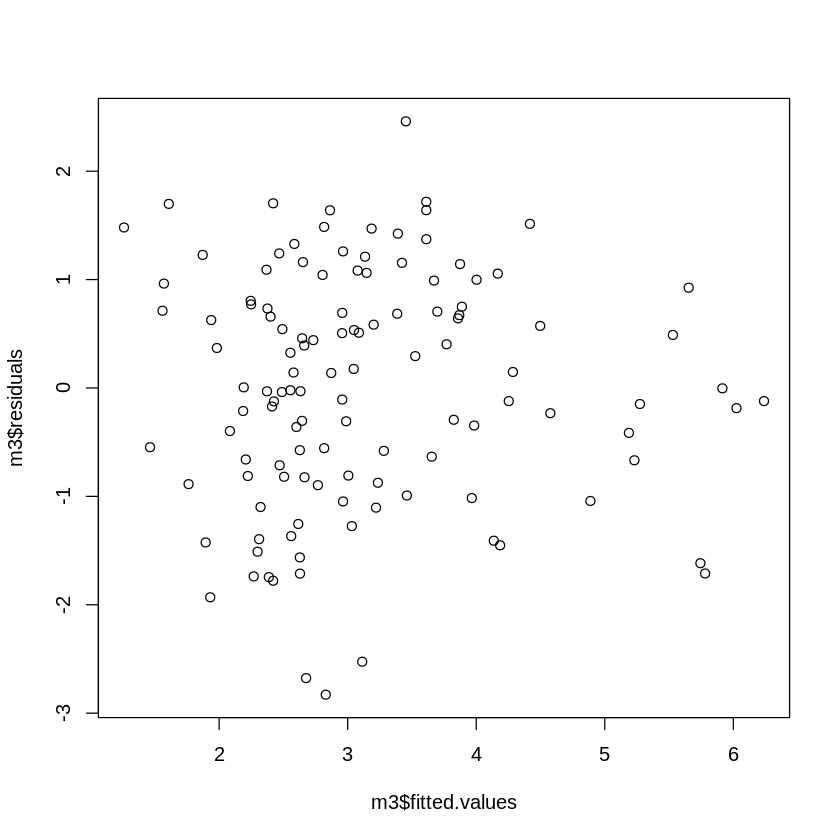

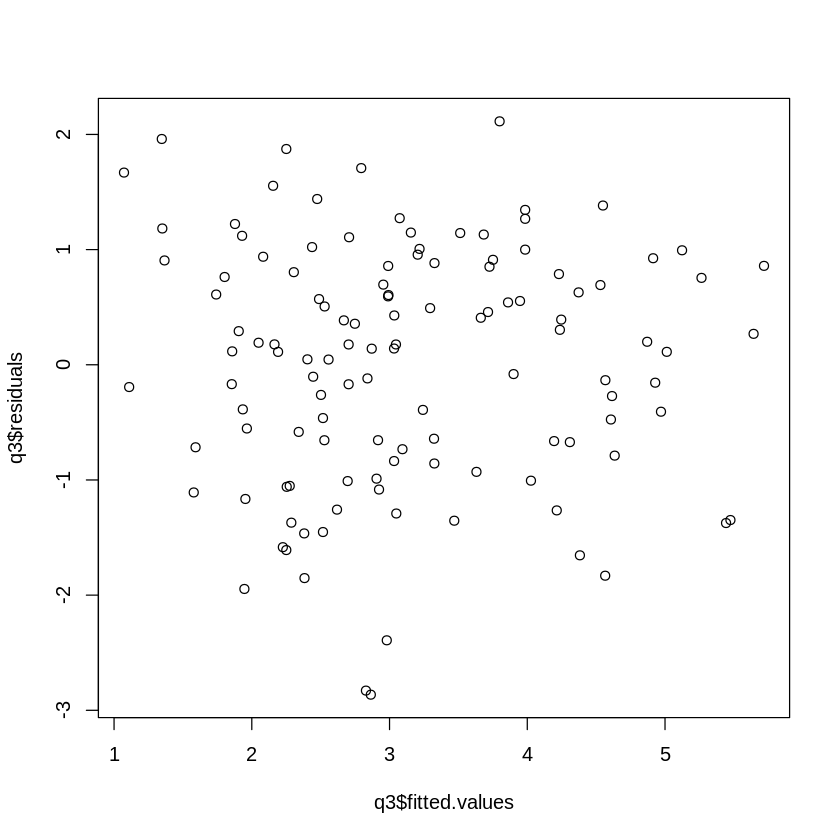

In [171]:
plot(m3$fitted.values, m3$residuals)
plot(q3$fitted.values, q3$residuals)


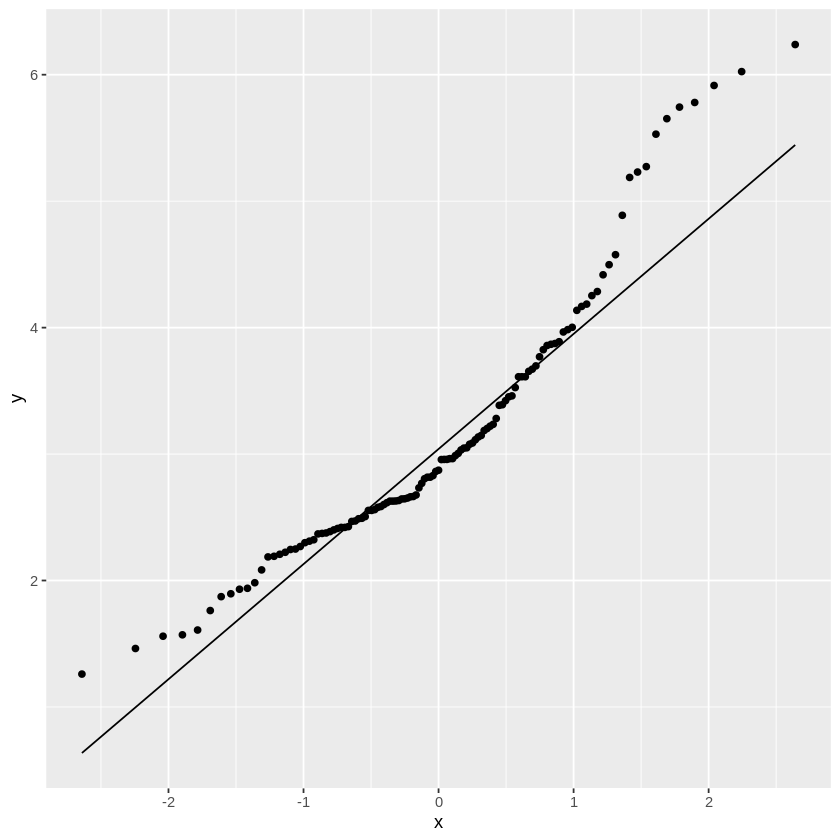

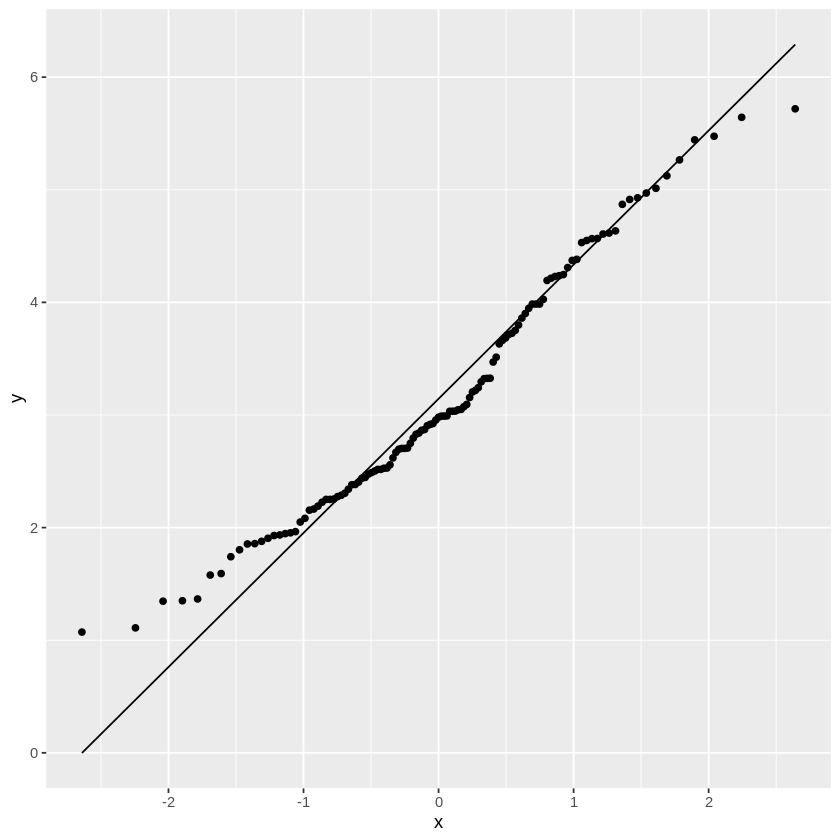

In [172]:
ggplot() + stat_qq(aes(sample = m3$fitted.values)) + stat_qq_line(aes(sample =  m3$fitted.values))
ggplot() + stat_qq(aes(sample = q3$fitted.values)) + stat_qq_line(aes(sample =  q3$fitted.values))

Quadratic version has lower AIC, higher adj R^2, and better QQ plot and residual plot. So with this set of features, I'd pick quadratic model.

Issues here is missing values in `pr_genre`. It says 129 were deleted due to missing values. But the plot looks good.

# Aside: Which transformation?

Explore non-linearity of some covariates

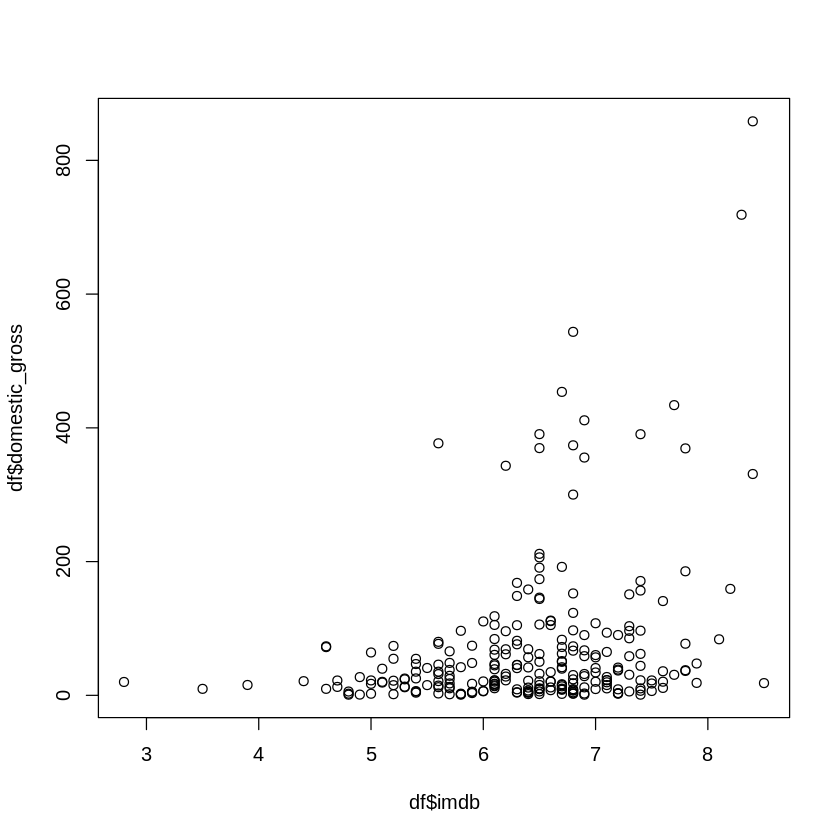

In [106]:
p1 = plot(y = df$domestic_gross, x = df$imdb)

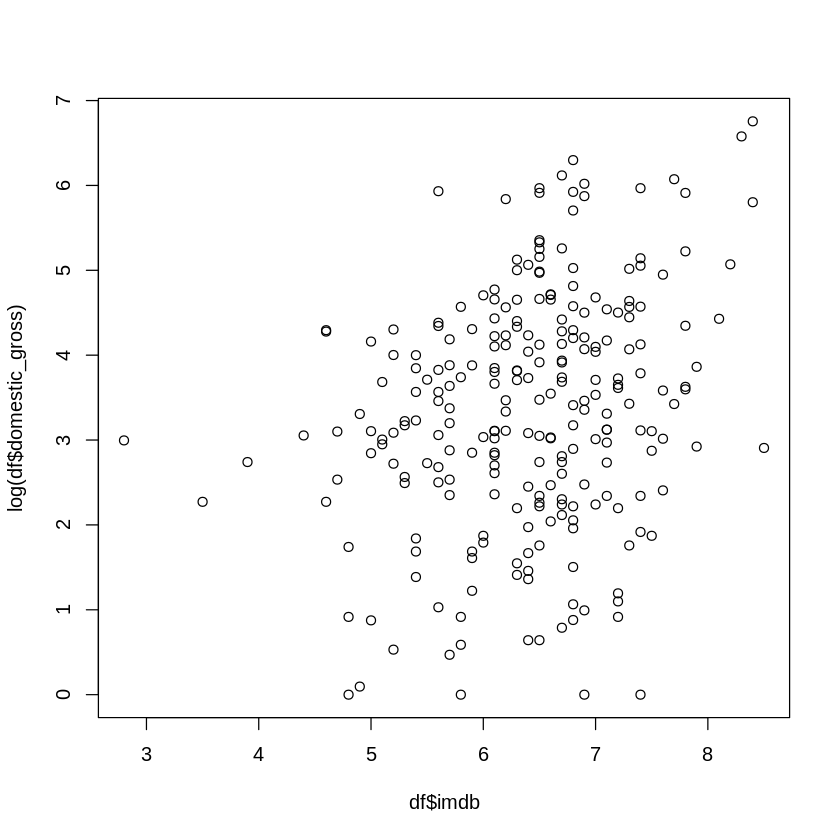

In [107]:
plog = plot(y = log(df$domestic_gross), x = df$imdb)

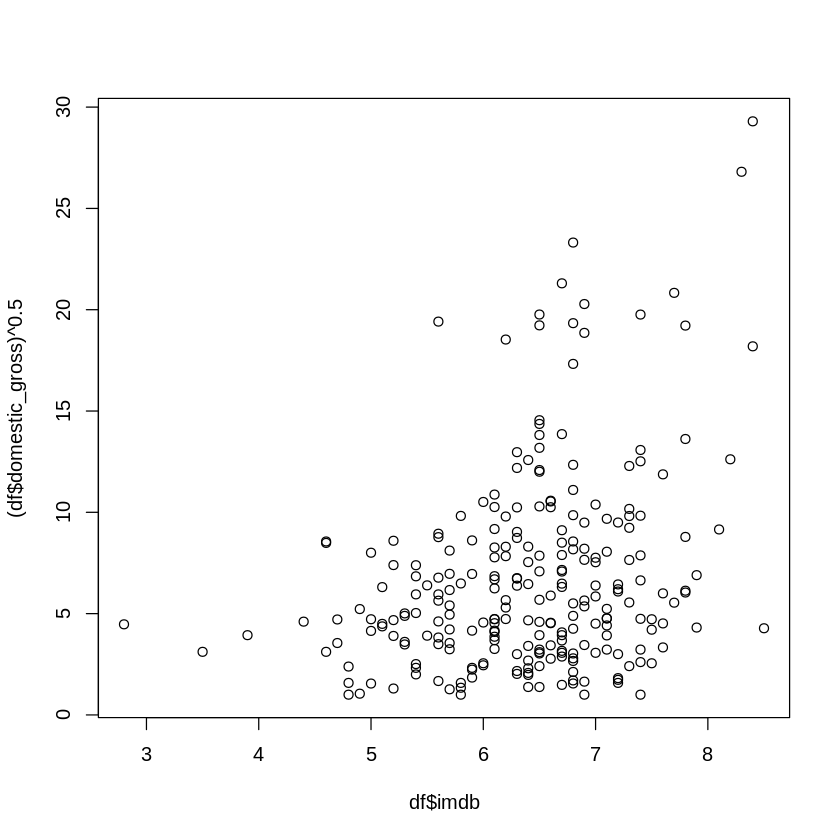

In [108]:
psqrt = plot(y = (df$domestic_gross)^0.5, x = df$imdb)

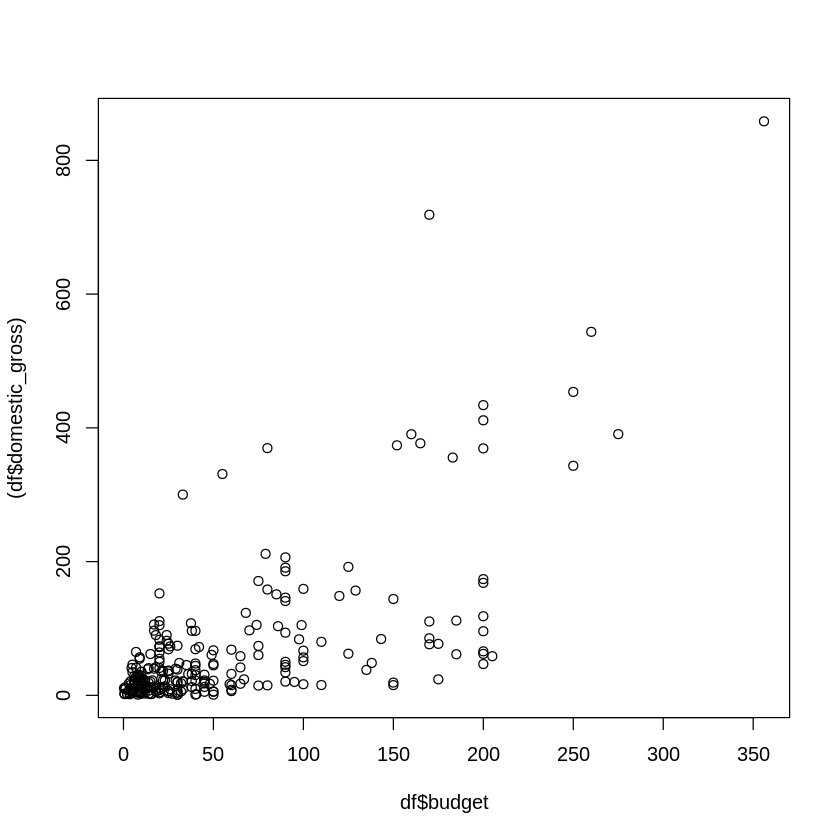

In [110]:
plot(y = (df$domestic_gross), x = df$budget)

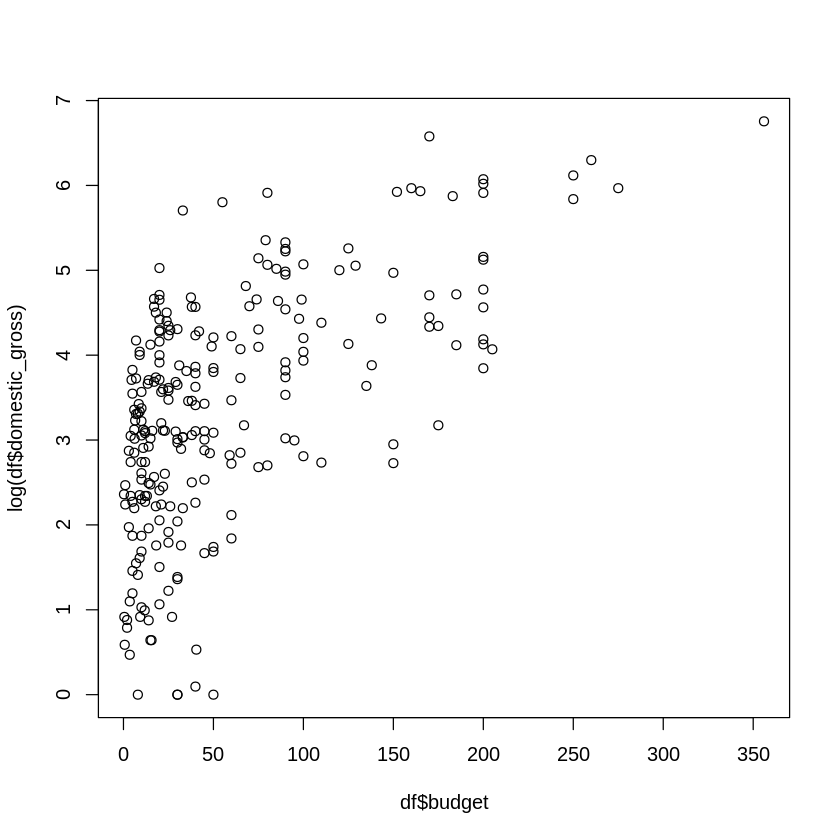

In [111]:
plot(y = log(df$domestic_gross), x = df$budget)

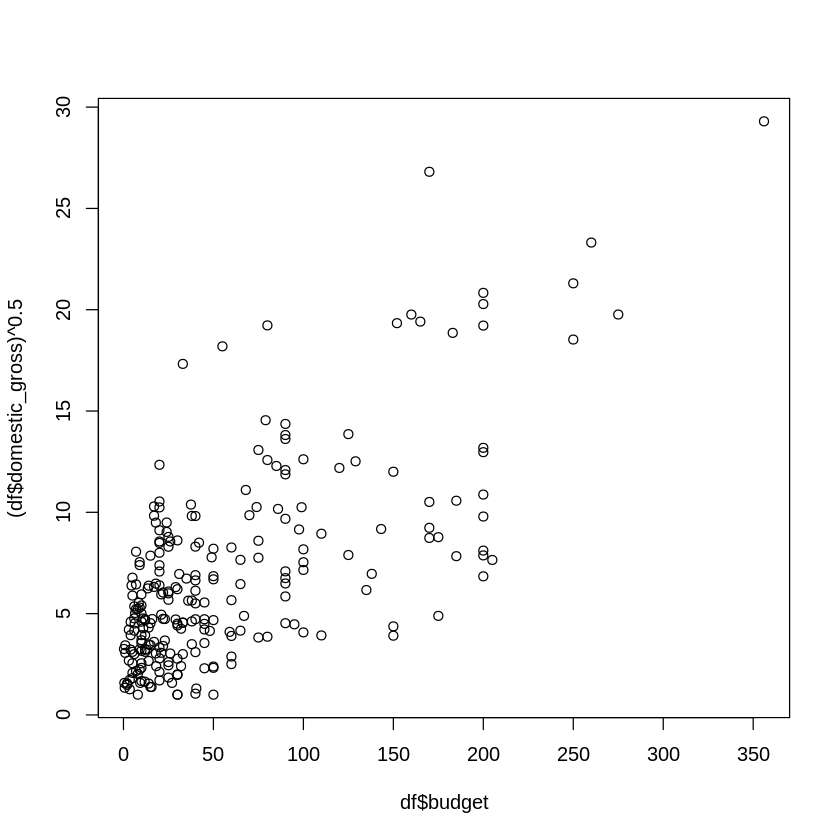

In [112]:
plot(y = (df$domestic_gross)^.5, x = df$budget)

It seems that sqrt() transformation is better from a point of view of `budget` but log() is better for `imdb`
So let's consider best selection of features for each case:
- case 1: sqrt() transformation.
- case 2: log()

In [115]:
slog = regsubsets(I(log(domestic_gross)) ~ oscar + budget + imdb + I(budget^2) + I(imdb^2), data = df)

In [117]:
slogs = summary(slog)
slogs$which
slogs$cp

,(Intercept),oscarOscar Winner,budget,imdb,I(budget^2),I(imdb^2)
1,TRUE,FALSE,TRUE,FALSE,FALSE,FALSE
2,TRUE,FALSE,TRUE,FALSE,FALSE,TRUE
3,TRUE,FALSE,TRUE,FALSE,TRUE,TRUE
4,TRUE,TRUE,TRUE,FALSE,TRUE,TRUE
5,TRUE,TRUE,TRUE,TRUE,TRUE,TRUE


[1] 19.263529  6.041326  2.853673  4.191789  6.000000

Warning message:
“Removed 1 rows containing missing values (`geom_point()`).”


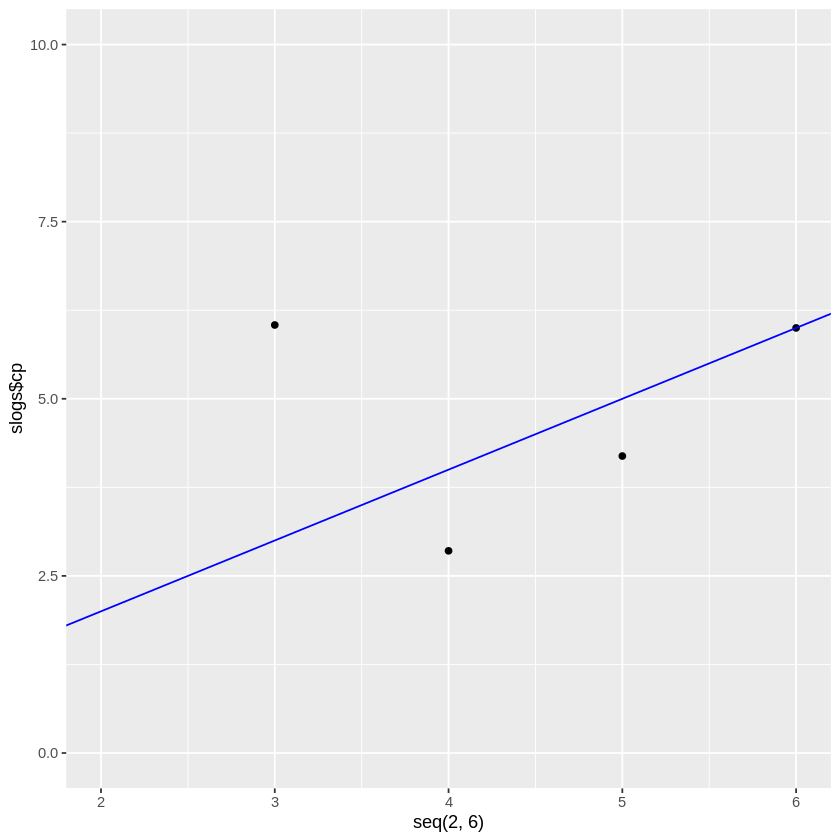

In [119]:
ggplot() +
  geom_point(aes(x = seq(2, 6), y = slogs$cp)) +
  geom_abline(intercept = 0, slope = 1, color = "blue") +
  ylim(0, 10)

In [128]:
ssq = regsubsets(I((domestic_gross)^.5) ~ oscar + budget + imdb + I(budget^2) + I(imdb^2), data = df[, c("domestic_gross", "oscar", "budget", "imdb")], method = "forward")

In [130]:
ssqs = summary(ssq)
ssqs$which
ssqs$cp

,(Intercept),oscarOscar Winner,budget,imdb,I(budget^2),I(imdb^2)
1,TRUE,FALSE,TRUE,FALSE,FALSE,FALSE
2,TRUE,FALSE,TRUE,FALSE,FALSE,TRUE
3,TRUE,TRUE,TRUE,FALSE,FALSE,TRUE
4,TRUE,TRUE,TRUE,FALSE,TRUE,TRUE
5,TRUE,TRUE,TRUE,TRUE,TRUE,TRUE


[1] 31.202770  5.942752  4.498427  4.570188  6.000000

Warning message:
“Removed 1 rows containing missing values (`geom_point()`).”


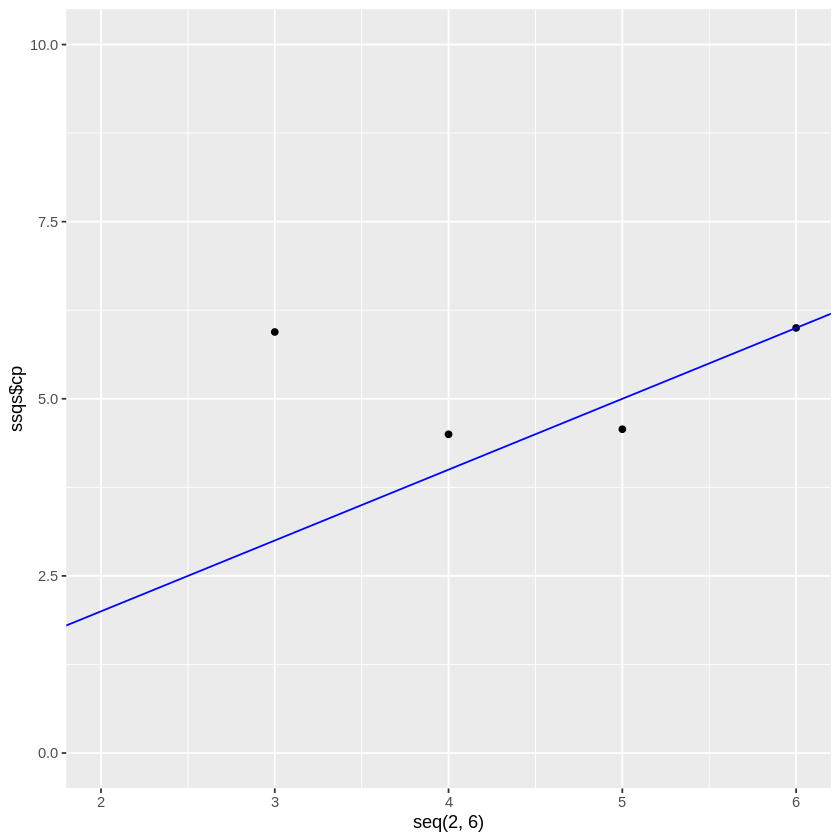

In [131]:
ggplot() +
  geom_point(aes(x = seq(2, 6), y = ssqs$cp)) +
  geom_abline(intercept = 0, slope = 1, color = "blue") +
  ylim(0, 10)

Problems with this approach. The suggested model sometimes only contain quadratic terms which is a violation. 

In [148]:
# log 
m5 = lm(I(log(domestic_gross)) ~ oscar + budget + imdb, data = df)
q5 <- lm(I(log(domestic_gross)) ~ oscar + poly(budget, 1) + poly(imdb, 2), data = df)

# anova_result <- anova(m5, q5)
# print(anova_result)

AIC(m5)
AIC(q5)

[1] 760.7036

[1] 762.4434

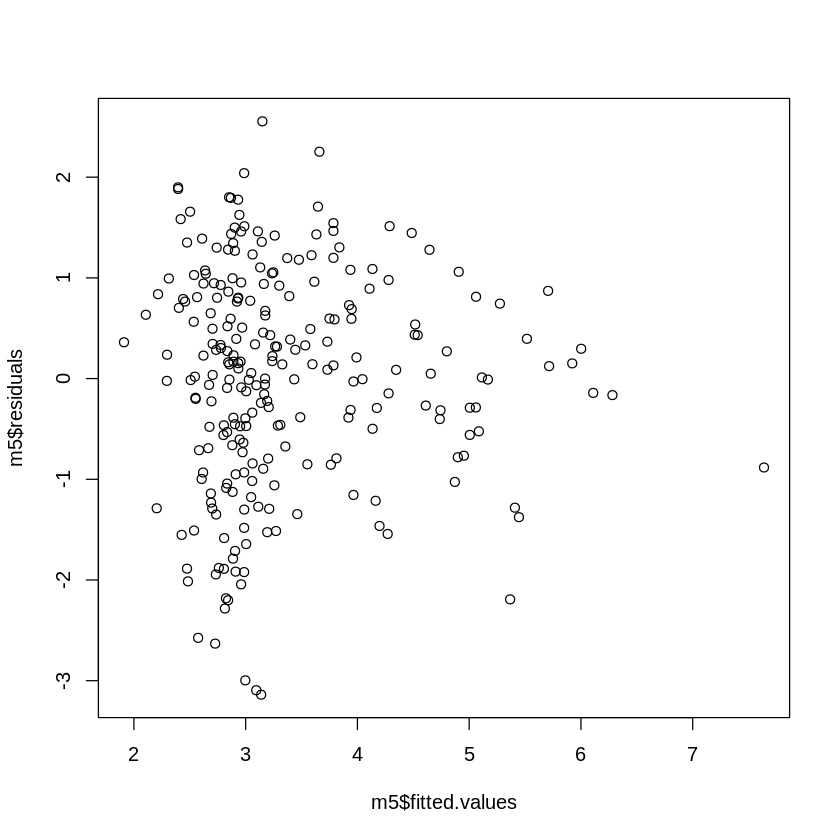

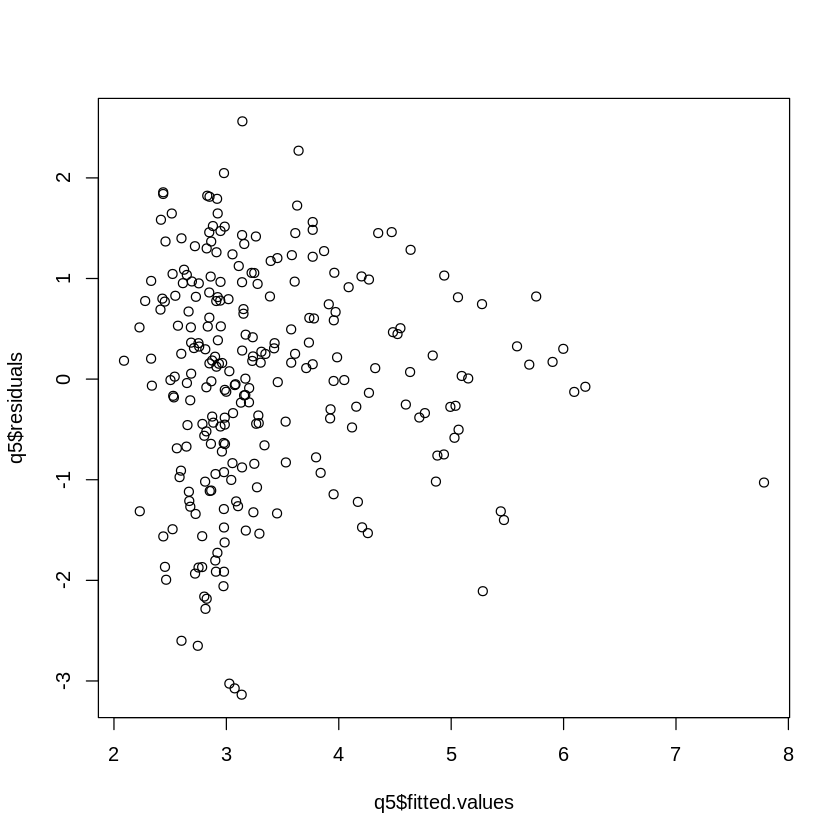

In [146]:
plot(m5$fitted.values, m5$residuals)
plot(q5$fitted.values, q5$residuals)

In [144]:
# sqrt
m6 <- lm(I(sqrt(domestic_gross)) ~ oscar + budget + imdb, data = df)
q6 <- lm(I(sqrt(domestic_gross)) ~ oscar + poly(budget, 1) + poly(imdb, 2), data = df)

AIC(m6)
AIC(q6)

[1] 1316.227

[1] 1316.223

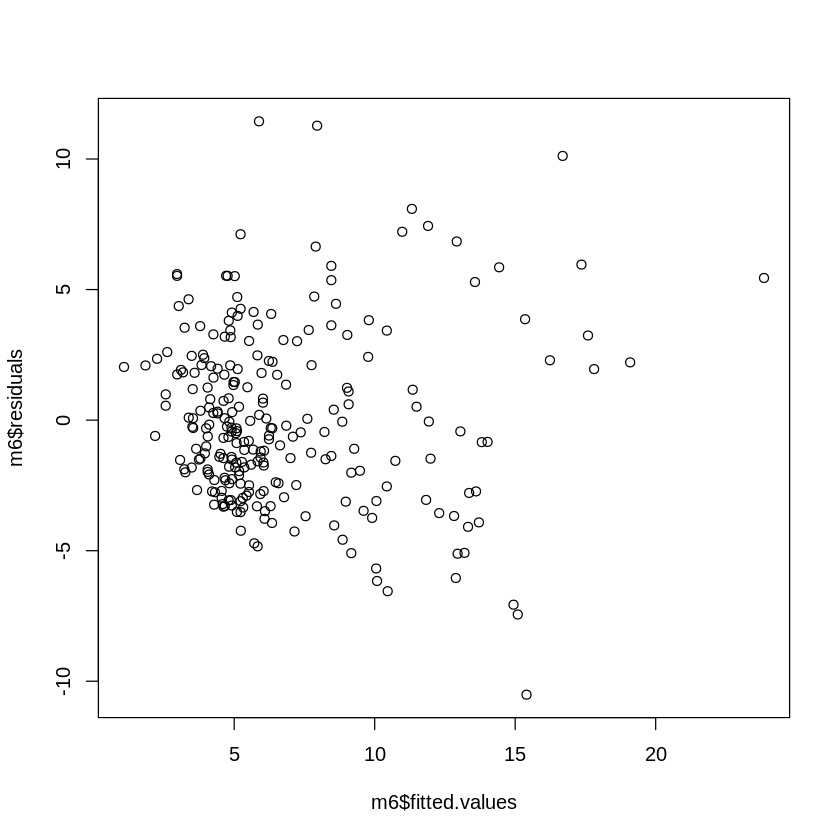

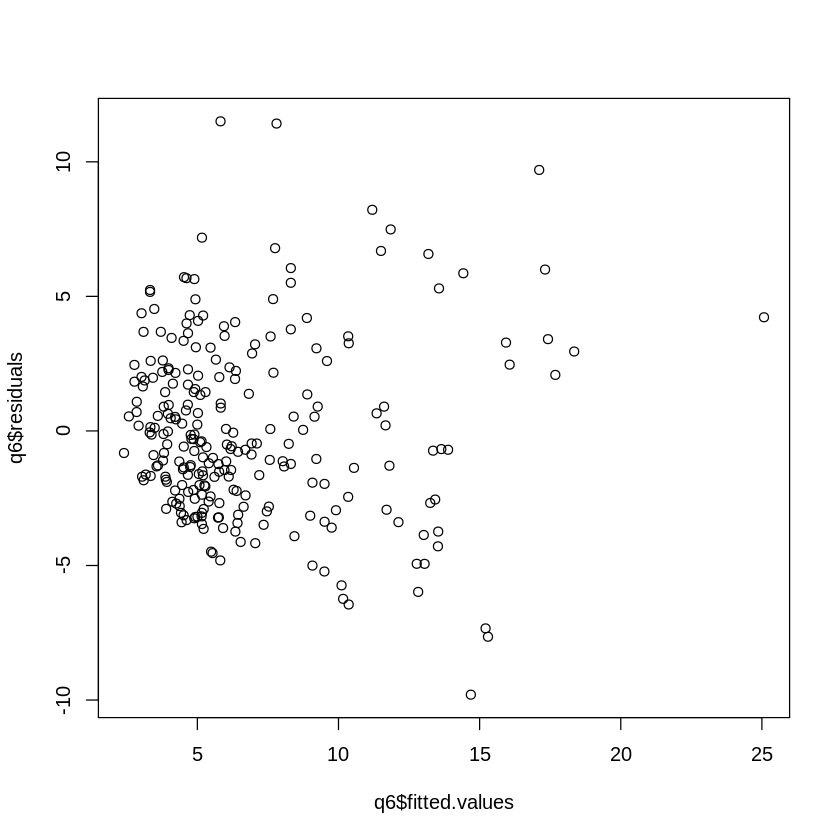

In [147]:
plot(m6$fitted.values, m6$residuals)
plot(q6$fitted.values, q6$residuals)

In terms of residual plot and AIC, log transformation seems more reasonable. 

# Inlcusion of other variables
Now it's pretty clear that
- some transformation on Y is critical. Log is a strong candidate. So I'll use log() from now on.
- Rating variables are not useful except for `imdb`
- After log(.) transformation, we don't see non-linearity in `imdb` but we do see that in `budget` so it might make sense to include quadratic terms for `budget`


In [159]:
m5 = lm(I(log(domestic_gross)) ~  oscar +  budget + imdb, data = df)
q5_0 <- lm(I(log(domestic_gross)) ~ oscar + poly(budget, 2) + imdb, data = df)

m5_1 = lm(I(log(domestic_gross)) ~  budget + imdb, data = df)
q5_1 <- lm(I(log(domestic_gross)) ~ poly(budget, 2) + imdb, data = df)

In [160]:
summary(m5)
summary(m5_1)


Call:
lm(formula = I(log(domestic_gross)) ~ oscar + budget + imdb, 
    data = df)

Residuals:
    Min      1Q  Median      3Q     Max 
-3.1389 -0.7063  0.1118  0.8075  2.5547 

Coefficients:
                  Estimate Std. Error t value Pr(>|t|)    
(Intercept)       0.908493   0.536579   1.693   0.0917 .  
oscarOscar Winner 0.432280   0.363587   1.189   0.2356    
budget            0.012565   0.001123  11.185   <2e-16 ***
imdb              0.268622   0.084171   3.191   0.0016 ** 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 1.095 on 246 degrees of freedom
Multiple R-squared:  0.3972,	Adjusted R-squared:  0.3898 
F-statistic: 54.03 on 3 and 246 DF,  p-value: < 2.2e-16



Call:
lm(formula = I(log(domestic_gross)) ~ budget + imdb, data = df)

Residuals:
    Min      1Q  Median      3Q     Max 
-3.1692 -0.6939  0.1003  0.8110  2.5271 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept) 0.705803   0.509202   1.386 0.166968    
budget      0.012761   0.001112  11.476  < 2e-16 ***
imdb        0.301534   0.079555   3.790 0.000189 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 1.096 on 247 degrees of freedom
Multiple R-squared:  0.3937,	Adjusted R-squared:  0.3888 
F-statistic:  80.2 on 2 and 247 DF,  p-value: < 2.2e-16


In [161]:
summary(q5_0)
summary(q5_1)


Call:
lm(formula = I(log(domestic_gross)) ~ oscar + poly(budget, 2) + 
    imdb, data = df)

Residuals:
    Min      1Q  Median      3Q     Max 
-3.1753 -0.6699  0.0833  0.8082  2.5233 

Coefficients:
                  Estimate Std. Error t value Pr(>|t|)    
(Intercept)        1.52158    0.53611   2.838 0.004918 ** 
oscarOscar Winner  0.36954    0.36217   1.020 0.308568    
poly(budget, 2)1  12.49740    1.10863  11.273  < 2e-16 ***
poly(budget, 2)2  -2.33619    1.09298  -2.137 0.033552 *  
imdb               0.28484    0.08391   3.395 0.000802 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 1.087 on 245 degrees of freedom
Multiple R-squared:  0.4082,	Adjusted R-squared:  0.3985 
F-statistic: 42.25 on 4 and 245 DF,  p-value: < 2.2e-16



Call:
lm(formula = I(log(domestic_gross)) ~ poly(budget, 2) + imdb, 
    data = df)

Residuals:
    Min      1Q  Median      3Q     Max 
-3.1852 -0.6676  0.0964  0.8256  2.4987 

Coefficients:
                 Estimate Std. Error t value Pr(>|t|)    
(Intercept)       1.35502    0.51070   2.653  0.00849 ** 
poly(budget, 2)1 12.66357    1.09670  11.547  < 2e-16 ***
poly(budget, 2)2 -2.42658    1.08948  -2.227  0.02683 *  
imdb              0.31342    0.07911   3.962 9.74e-05 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 1.087 on 246 degrees of freedom
Multiple R-squared:  0.4057,	Adjusted R-squared:  0.3984 
F-statistic: 55.98 on 3 and 246 DF,  p-value: < 2.2e-16


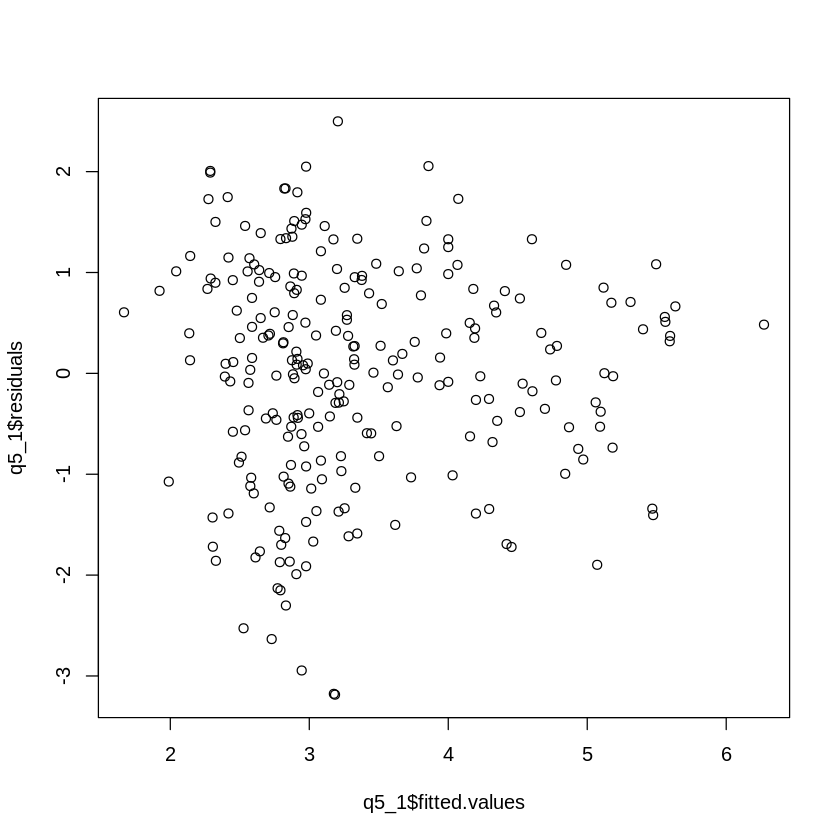

In [164]:
plot(q5_1$fitted.values, q5_1$residuals)

In [166]:
AIC(q5_0)
AIC(q5_1)
# almost the same so we might just go with non-quadratic one

[1] 758.0846

[1] 757.1447